# Problem Description

My final project will be focusing on Facial Expression Recognition or FER. FER is the task of automatically identifying the emotional state of a person based on their facial expression using image data. It is an important aspect of computer vision and HCI. There are tons of applications in various domains like healthcare, robotics, virtual reality, etc. The goal here is to build a model that can accurately classify images of human faces into emotion categories.

In [1]:
pip install scipy==1.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 47.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.
Note: you may need to restart the kernel to use updated pac

In [2]:
import math
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import scikitplot
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import he_normal


# Exploratory Data Analysis

In [3]:
# Load the data
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')

In [4]:
df.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [7]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [8]:
emotion_to_text_mapping = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

In [9]:
# get the size of the image
len_pixels = len(df.pixels[0].split(' '))
size = int(math.sqrt(len_pixels))
print('Size of the image: ' + str(size) + ' x ' + str(size))

Size of the image: 48 x 48


**Findings:**

* Data size is 35887 rows by 3 columns
* Each facial expression emotion is categorized by integer values
* Usage column indicates whether a sample is for training or testing purposes
* There are no missing nor null values
* Emotion column is categorized into 7 different emotion categories

In [10]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

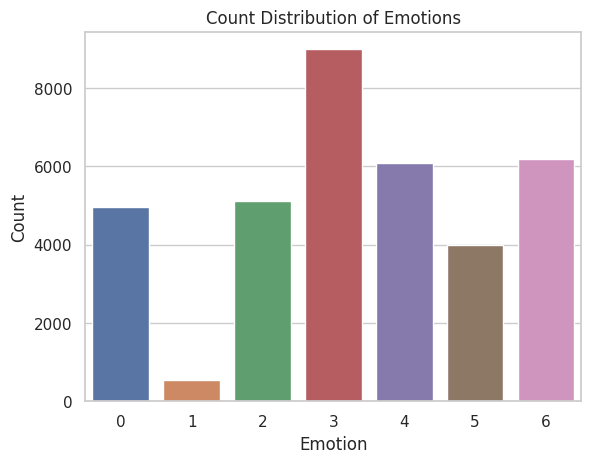

In [11]:
sns.set(style='whitegrid')
sns.countplot(x='emotion', data=df)

plt.title('Count Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

**Findings**

* 3, 4, 6 are the majority of the dataset. These are mapped to: 3 -> happiness, 4 -> sad, 6 -> neutral
* For simplification purposes, we're going to focus on these 3 major categories, as we don't really care about the other emotions

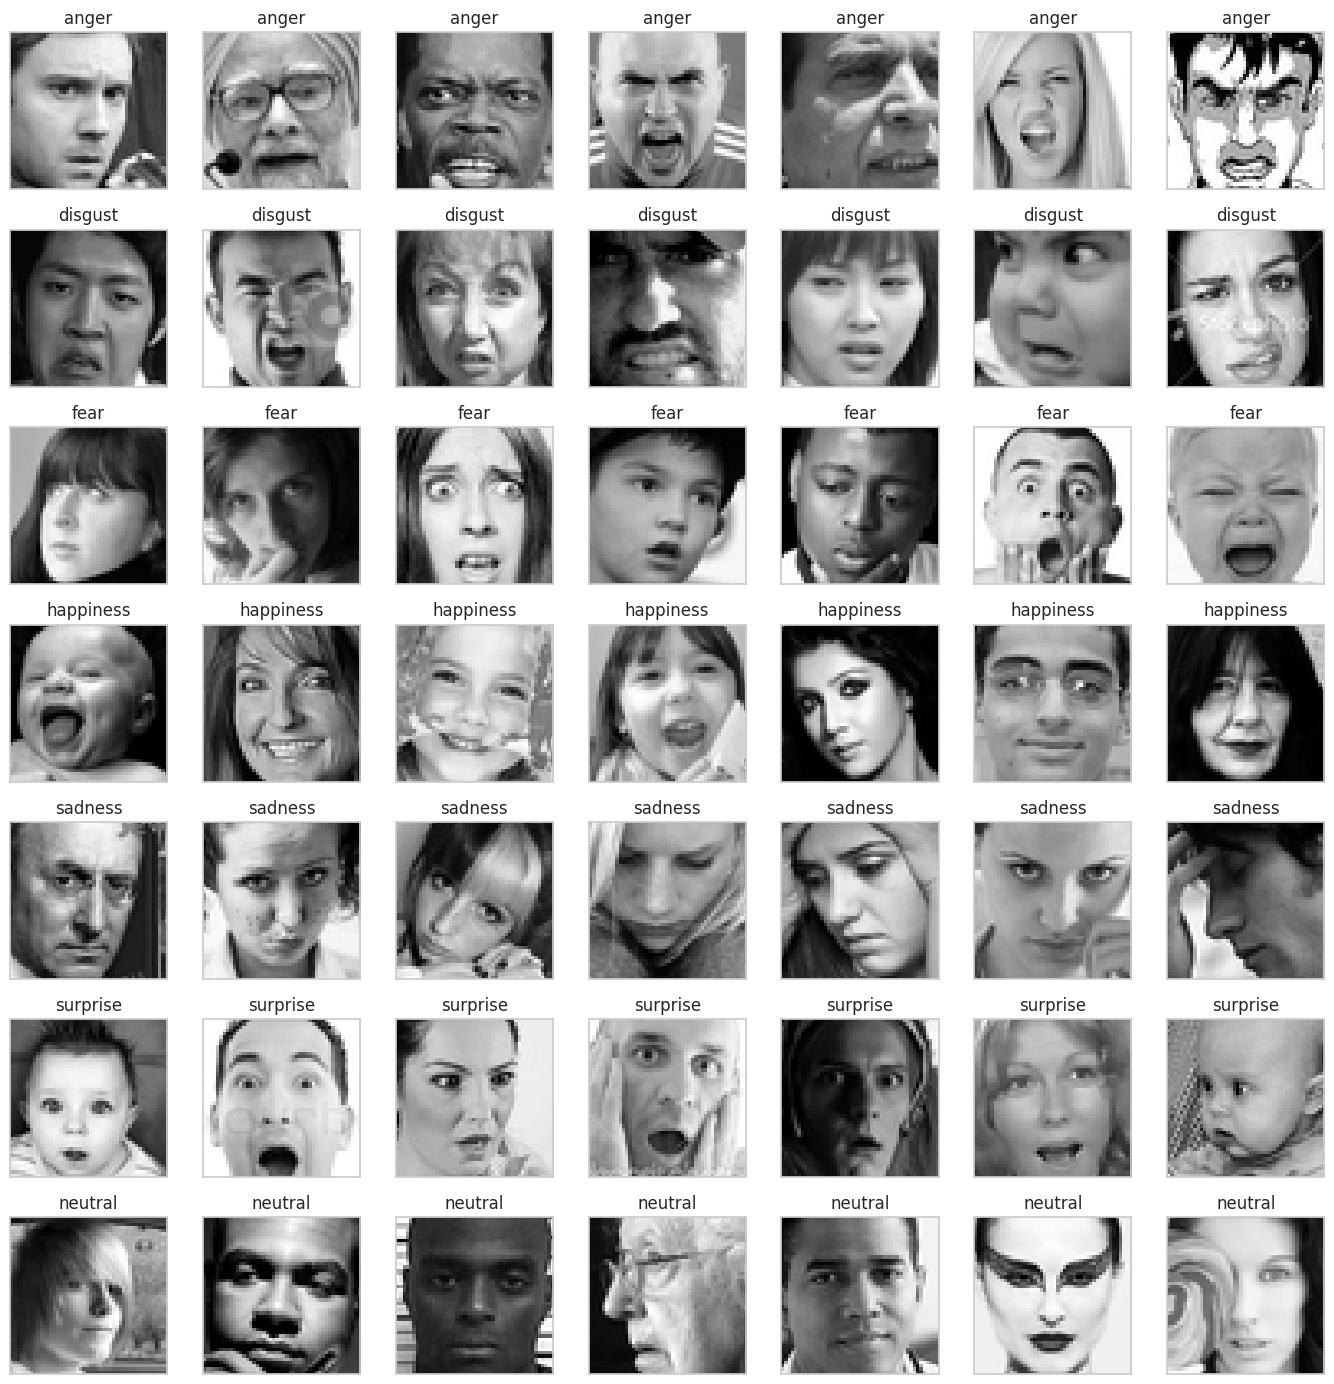

In [12]:
# display emotions
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_to_text_mapping[label])
        plt.tight_layout()

In [13]:
interested_emotions = [3, 4, 6]
df = df[df.emotion.isin(interested_emotions)]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 21264 entries, 3 to 35885
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  21264 non-null  int64 
 1   pixels   21264 non-null  object
 2   Usage    21264 non-null  object
dtypes: int64(1), object(2)
memory usage: 664.5+ KB
None


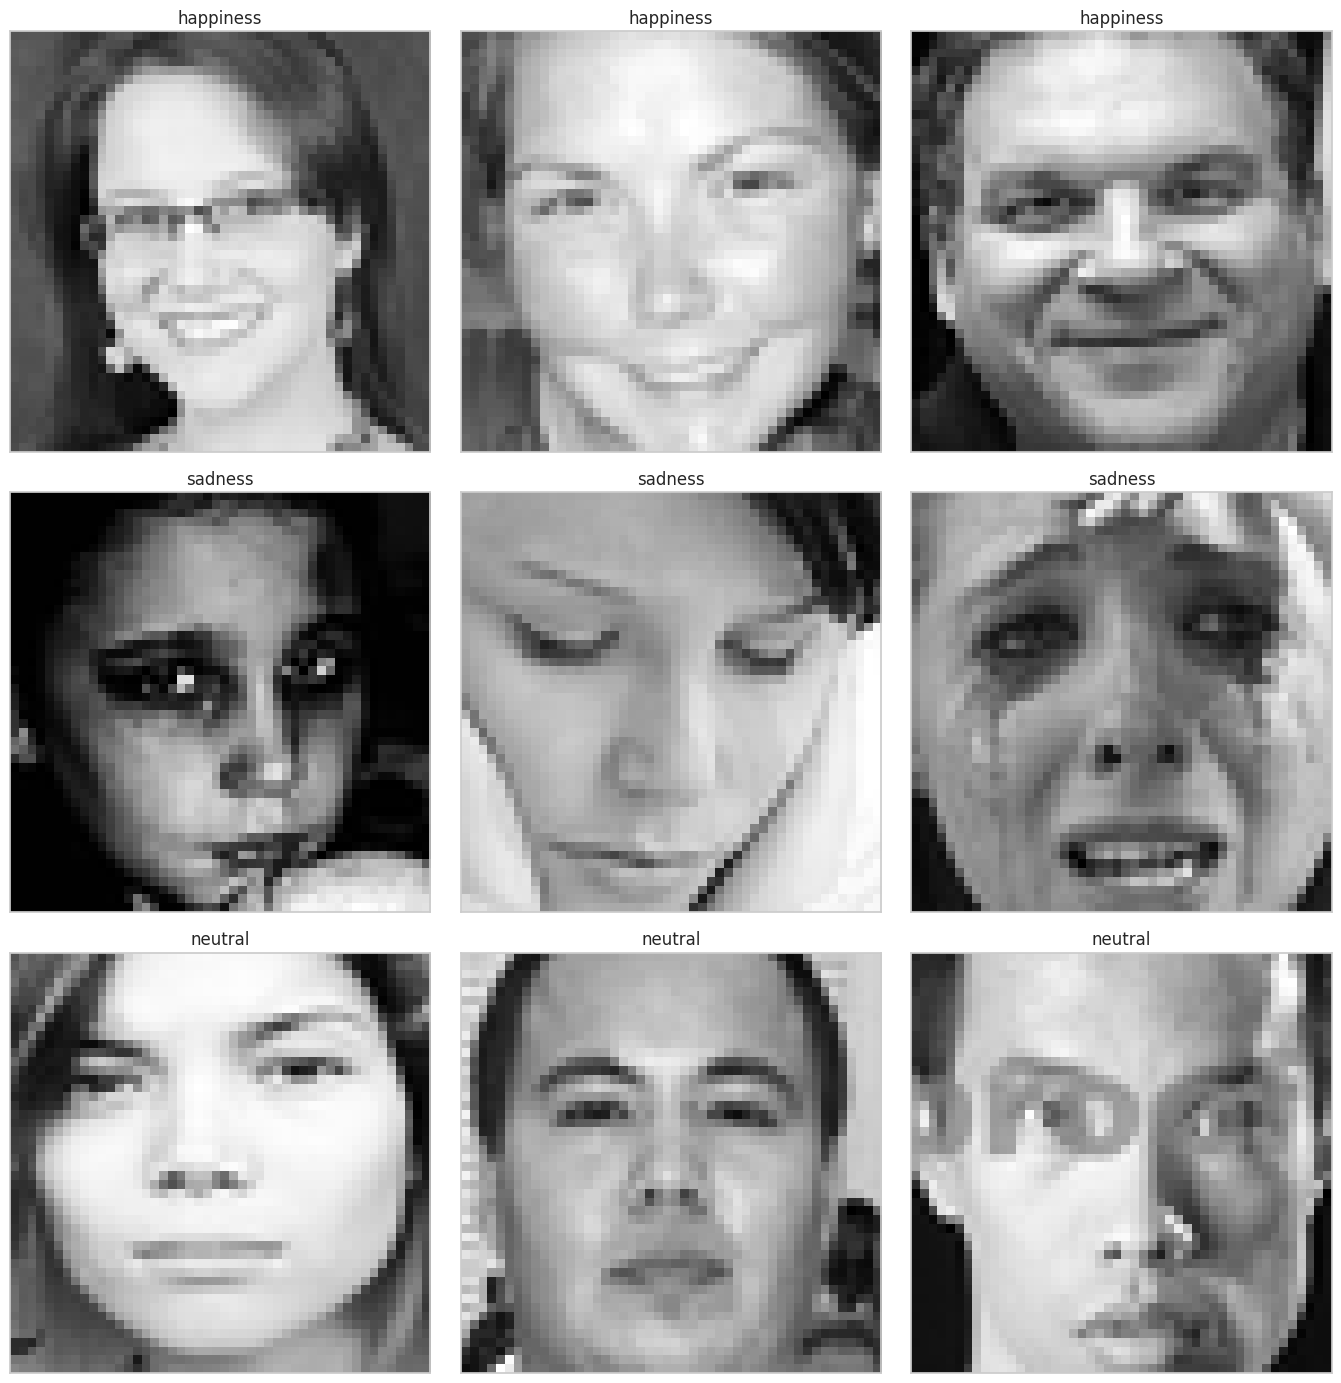

In [14]:
# display emotions for the interested labesl
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(3, 3, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_to_text_mapping[label])
        plt.tight_layout()

# Model Architecture

**Data Preprocessing**

In [15]:
# For feeding the input data into our CNN model, we'll first transform each row
# into 48x48 3D dimension and then stack them up
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [16]:
img_array.shape

(21264, 48, 48, 1)

In [17]:
# transform labeling into one-hot encoding format
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [18]:
# one-hot encoding to emotion mapping for look-up purposes
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


In [19]:
# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [20]:
# freeing up memory
del df
del img_array
del img_labels

In [21]:
# we are normalizing our image data here as neural networks tend to perform
# better and converge faster when the input data is normalized to a consistent scale.
x_train = x_train / 255.
x_test = x_test / 255.

**Building CNN**

In [22]:
def build_network(optimizer):
    """
    Constructs a Deep Convolutional Neural Network (DCNN) with ELU activation, Batch Normalization,
    and Dropout layers for regularization. `he_normal` initializer is used to suit the ELU activation.
    """
    img_width = x_train.shape[1]
    img_height = x_train.shape[2]
    img_depth = x_train.shape[3]
    num_classes = y_train.shape[1]
    model = Sequential(name='Deep_CNN')

    # First convolutional block
    model.add(Conv2D(64, (5, 5), activation='elu', kernel_initializer=he_normal(),
                     padding='same', input_shape=(img_width, img_height, img_depth), name='conv_block1_conv1'))
    model.add(BatchNormalization(name='conv_block1_bn1'))
    model.add(Conv2D(64, (5, 5), activation='elu', kernel_initializer=he_normal(),
                     padding='same', name='conv_block1_conv2'))
    model.add(BatchNormalization(name='conv_block1_bn2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='conv_block1_pool'))
    model.add(Dropout(0.4, name='conv_block1_dropout'))

    # Second convolutional block
    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer=he_normal(),
                     padding='same', name='conv_block2_conv1'))
    model.add(BatchNormalization(name='conv_block2_bn1'))
    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer=he_normal(),
                     padding='same', name='conv_block2_conv2'))
    model.add(BatchNormalization(name='conv_block2_bn2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='conv_block2_pool'))
    model.add(Dropout(0.4, name='conv_block2_dropout'))

    # Third convolutional block
    model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer=he_normal(),
                     padding='same', name='conv_block3_conv1'))
    model.add(BatchNormalization(name='conv_block3_bn1'))
    model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer=he_normal(),
                     padding='same', name='conv_block3_conv2'))
    model.add(BatchNormalization(name='conv_block3_bn2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='conv_block3_pool'))
    model.add(Dropout(0.5, name='conv_block3_dropout'))

    # Fully connected layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(128, activation='elu', kernel_initializer=he_normal(), name='fc1'))
    model.add(BatchNormalization(name='fc1_bn'))
    model.add(Dropout(0.6, name='fc1_dropout'))

    # Output layer
    model.add(Dense(num_classes, activation='softmax', name='output'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Display model architecture
    model.summary()

    return model


In [23]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [24]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
augmentation_params = dict(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

train_datagen = ImageDataGenerator(**augmentation_params)

# Fit the generator on the training data
train_datagen.fit(x_train)

In [25]:
batch_size = 32 # batch size of 32 performs the best. have also tried 12, 64, 128
epochs = 100 # 100 gives the best result

model = build_network(optimizers.Adam(0.001)) 
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Deep_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block1_conv1 (Conv2D)      │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block1_bn1                 │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block1_conv2 (Conv2D)      │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block1_bn2                 │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block1_pool (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block1_dropout (Dropout)   │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block2_conv1 (Conv2D)      │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block2_bn1                 │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block2_conv2 (Conv2D)      │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block2_bn2                 │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block2_pool (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block2_dropout (Dropout)   │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block3_conv1 (Conv2D)      │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block3_bn1                 │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block3_conv2 (Conv2D)      │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block3_bn2                 │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block3_pool (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block3_dropout (Dropout)   │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1_bn (BatchNormalization)     │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1_dropout (Dropout)           │ (None, 128)            │             

 Total params: 2,395,075 (9.14 MB)

 Trainable params: 2,393,027 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729081714.418158      77 service.cc:145] XLA service 0x7ebe4001cb10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729081714.418217      77 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 11/598 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.3893 - loss: 2.2378

I0000 00:00:1729081725.693696      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


598/598 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - accuracy: 0.3849 - loss: 1.6018 - val_accuracy: 0.5331 - val_loss: 0.9733 - learning_rate: 0.0010
Epoch 2/100
  1/598 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.4688 - loss: 1.0835

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.4688 - loss: 1.0835 - val_accuracy: 0.5341 - val_loss: 0.9732 - learning_rate: 0.0010
Epoch 3/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.4808 - loss: 1.0374 - val_accuracy: 0.5717 - val_loss: 0.8995 - learning_rate: 0.0010
Epoch 4/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.4688 - loss: 1.0906 - val_accuracy: 0.5703 - val_loss: 0.8985 - learning_rate: 0.0010
Epoch 5/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5305 - loss: 0.9604 - val_accuracy: 0.4701 - val_loss: 1.0682 - learning_rate: 0.0010
Epoch 6/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.5938 - loss: 0.8005 - val_accuracy: 0.4758 - val_loss: 1.0654 - learning_rate: 0.0010
Epoch 7/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5847 - loss: 0.8608 - val_accuracy: 0.6244 - val_loss: 0.7692 - learning_rate: 0.0010
Epoch 8/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.6250 - loss: 

# Results and Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

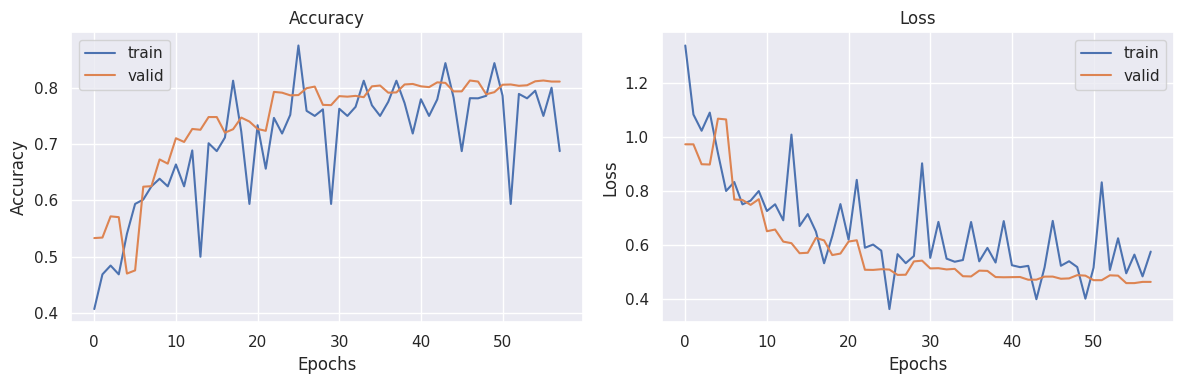

In [26]:
# Setting up Seaborn style for the plots
sns.set()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot on the left
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train', ax=axes[0])
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid', ax=axes[0])
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')

# Loss plot on the right
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train', ax=axes[1])
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid', ax=axes[1])
axes[1].set_title('Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

**Findings:**

* Accuracy plot: 
    - The training accuracy increases consistently from the start, with some fluctuations around the 40-70 epoch mark. This model reaches a maximum accuracy of around 0.9, which is really good.
    - Going back to the fluctuations.. it could mean that after the 40th epoch, the model might be learning some aspects or patterns of the data that's not generalizable or some overfitting is happening. Early stopping, in this case, came in handy.
    - Validation accuracy increases consistently but plateaus at around 0.8. After that, it stays relatively stable, with fewer fluctuations than the training accuracy. This indicates that the model is not overfitting and nearing optimal.

* Loss plot:
    - The training loss decreases steadily, with pretty noticeable fluctuations in the later epochs. These fluctuations could be related to the fluctations observed in the training accuracy, indicating some model instability.
    - The loss drops from above 1.2 to 0.4, showing that the model has learned pretty effectively over time.
    - The validation loss mirrors the behavior of the validation accuracy, it decreases quickly and plateaus after around 20 epochs, stabilizing around 0.5-0.4.
    - Validation loss doesn't fluctuate as much as training loss, suggesting that the model has decent generalization, but isn't learning much after 20th epoch.

* Potential Improvement:
    - Could early stop earlier since validation accuracy and loss plateaus arund 20th epoch. Could probably stop at 30 epoch.
    - Could experiment more with regularization techniques like increasing dropout to improve generalization.
    - Could also reduce learning rate more after 20th epoch to stabilize training.

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


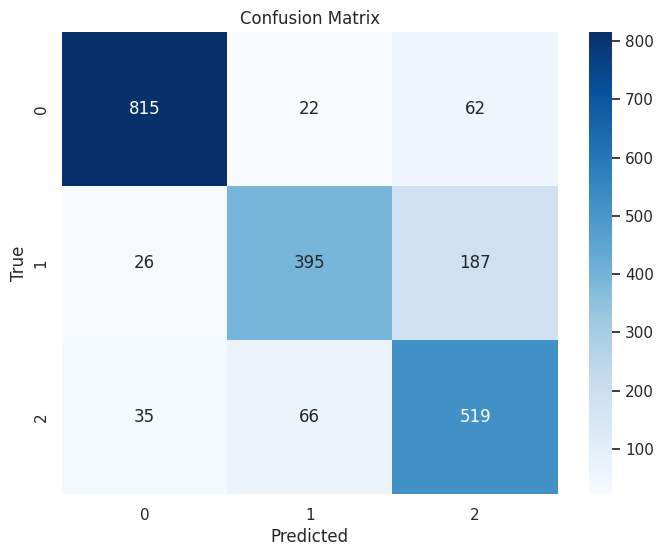

In [27]:
# confusion matrix to see how well the model is performing across different classes.
# Get model predictions
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Findings:**

* The model is pretty good at identifying class 0, but seems to struggle with the other two. The struggle for the other two could be due to overlapping features, which the model is finding hard to differentiate.
* Class 2 has the higest misclassification rates, suggesting the model might need more training on the features that distinguish these two classes (1 and 2), or perhaps additional hyperparameter tuning is needed.